## Initialisation

### Dependencies

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize 
from sklearn.linear_model import LinearRegression

### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow $ True Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $s \rightarrow$ Engineering Stress

## Utils

### Function to calculate derivative

In [2]:
class DerivativeError(Exception):
    def __init__(self, message):
        super().__init__(message)

def calculate_difference(points):
    d_points = []
    for i in range(0,len(points)-1):
        p1 = points[i]
        p2 = points[i+1]
        d_points.append(p2-p1)
    return d_points

def differentiate(x, y):
    if len(x) != len(y):
        raise DerivativeError('Unequal datapoints in the dataset')
    x = calculate_difference(x)
    y = calculate_difference(y)
    i = 0
    consider = []
    while (i<len(x)):
        if x[i] == 0 or y[i]/x[i] > 1 or y[i]/x[i] < 0: # neglect all values where n > 1 or n < 0
            x = x[:i] + x[i+1:]
            y = y[:i] + y[i+1:]
            continue
        consider.append(i)
        i+=1
    return x,  y, [y[i]/x[i] for i in range(len(x))], consider

### Remove elements

In [3]:
def remove(l, consider):
    temp = []
    for i in consider:
        temp.append(l[i])
    return temp

## Engineering Strain v/s Engineering Stress

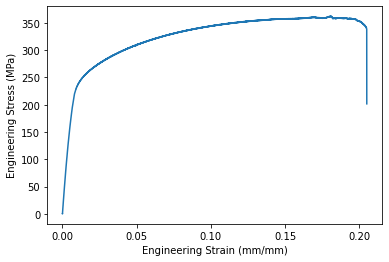

In [4]:
x_label = 'Engineering Strain (mm/mm)'
y_label = 'Engineering Stress (MPa)'
dataset = pd.read_csv('./tensile_test_data.csv', sep='\t', names=[x_label, y_label])
x = dataset[x_label]
y = dataset[y_label]
plt.xlabel(x_label)
plt.ylabel(y_label)
_ = plt.plot(x,y)

**Why is the engineering stress negative initially?**

One reason could be the sample is a little longer than the space between the clamps. This results in compression of the specimen initially.

### Fit a linear curve onto the seemingly straight line

Young's Modulus: 28.343567180375043 GPa


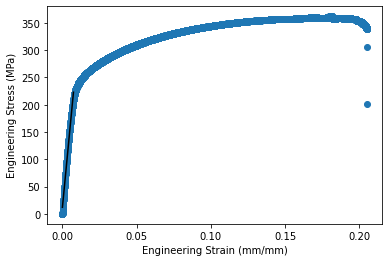

In [5]:
point_until_straight = 698 # point upto which the curve seems straight
coefs = np.polyfit(x[:point_until_straight], y[:point_until_straight], 1)
plt.figure()
y_fit = np.polyval(coefs, x[:point_until_straight])
_ = plt.plot(x[:point_until_straight], y_fit, color='black')
plt.scatter(x,y)
plt.xlabel(x_label)
plt.ylabel(y_label)
# The line formed is straight so it does not matter which coordinates are taken
youngs_modulus = (y_fit[100]-y_fit[99])/(x[100]-x[99])
print(f'Young\'s Modulus: {youngs_modulus/1000} GPa')

### Calculating Yield Strength 

Yield Strength: 236.48302 MPa


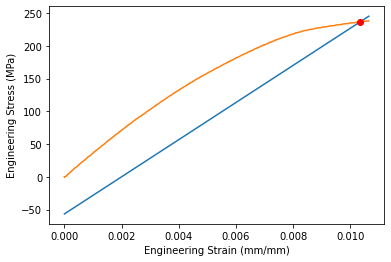

In [6]:
required_points = 1000
parallel_line_y = [(i - 0.002)*youngs_modulus for i in x[:required_points]]
plt.plot(x[:required_points], parallel_line_y)
plt.plot(x[:required_points],y[:required_points])
intersection = np.argwhere(np.diff(np.sign(parallel_line_y - y[:required_points]))).flatten()
plt.plot(x[intersection], y[intersection], 'ro')
plt.xlabel(x_label)
plt.ylabel(y_label)
yield_strength = y[intersection[0]]
# 0th index because there is only one intersection point
print(f'Yield Strength: {y[intersection[0]]} MPa')

### Calculating Ultimate Tensile Strength

Ultimate Tensile Strength is 362.27072 MPa at 18.095% elongation.


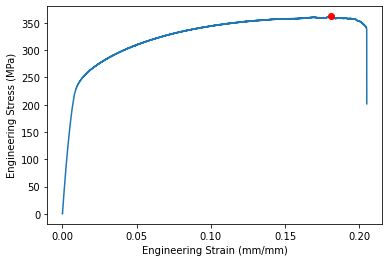

In [7]:
# Fetch the max value of the engineering stress from the dataset.
uts_abscissa = 0
uts = y[uts_abscissa]
for i in range(0,len(y)):
    if y[i] >= uts:
        uts = y[i]
        uts_abscissa = i
uts_strain = x[uts_abscissa]
plt.plot(x,y)
plt.plot(uts_strain, uts, 'ro')
plt.xlabel(x_label)
plt.ylabel(y_label)
print(f'Ultimate Tensile Strength is {uts} MPa at {uts_strain*100}% elongation.')

### Required region for plasticity analysis

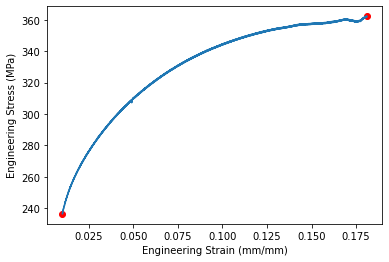

In [8]:
plt.plot(x[intersection], y[intersection], 'ro') # YS
plt.plot(uts_strain, uts, 'ro') # UTS
# there is only one intersection point
start = intersection[0]
end = uts_abscissa+1
plt.plot(x[start:end], y[start:end])
# _ supresses ouput while setting x,y labels
_ = plt.xlabel(x_label)
_ = plt.ylabel(y_label)

## True Strain v/s True Stress

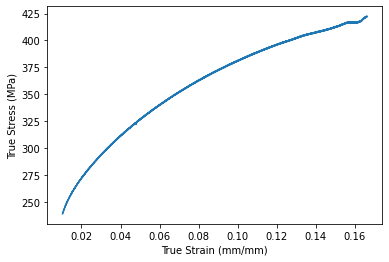

In [9]:
true_strain = np.log([i+1 for i in x[start:end]])
required_points = len(true_strain)
true_stress = [y[start+i]*(1+true_strain[i]) for i in range(required_points)]
_ = plt.plot(true_strain, true_stress)
_ = plt.xlabel('True Strain (mm/mm)')
_ = plt.ylabel('True Stress (MPa)')

## True Plastic Strain v/s True Stress

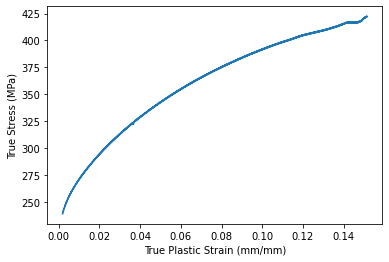

In [10]:
# true plastic strain = true stain - (true stress)/(young's modulus)
true_plastic_strain = [(true_strain[i] - true_stress[i]/youngs_modulus) for i in range(required_points)]
_ = plt.plot(true_plastic_strain, true_stress)
_ = plt.xlabel('True Plastic Strain (mm/mm)')
_ = plt.ylabel('True Stress (MPa)')

## Calculation of work hardening rate

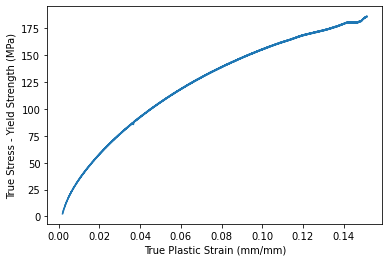

In [11]:
sigma_sigma_ys = [(i-yield_strength) for i in true_stress]
_ = plt.plot(true_plastic_strain, sigma_sigma_ys)
_ = plt.xlabel('True Plastic Strain (mm/mm)')
_ = plt.ylabel('True Stress - Yield Strength (MPa)')

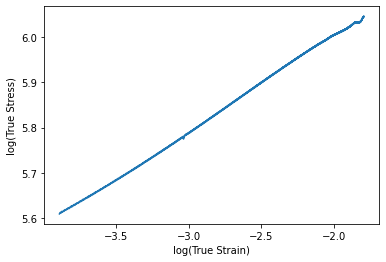

In [12]:
required_points_plasticity = 965 # 965 is the index for the beginning of plastic region.
log_true_strain = np.log(true_strain[required_points_plasticity:]) 
log_true_stress = np.log(true_stress[required_points_plasticity:])
_ = plt.plot(log_true_strain, log_true_stress)
_ = plt.xlabel('log(True Strain)')
_ = plt.ylabel('log(True Stress)')

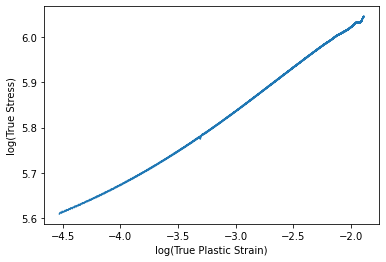

In [13]:
log_true_plastic_strain = np.log(true_plastic_strain[required_points_plasticity:])
_ = plt.plot(log_true_plastic_strain, log_true_stress)
_ = plt.xlabel('log(True Plastic Strain)')
_ = plt.ylabel('log(True Stress)')

$ \sigma = K \times \epsilon^n $
$ \Rightarrow \frac{d\sigma}{d\epsilon} = n $

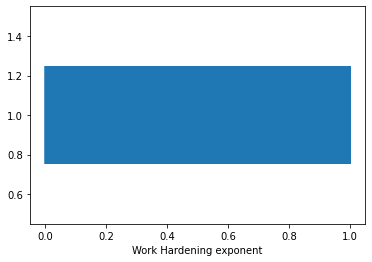

In [14]:
diff = differentiate(log_true_strain, log_true_stress)
sanitised_log_true_strain = diff[0]
sanitised_log_true_stress = diff[1]
work_hardening_exponent = diff[2]
consider = diff[3]
sanitised_true_strain = remove(true_strain, consider)
sanitised_true_stress = remove(true_stress, consider)
_ = plt.eventplot(work_hardening_exponent, linelengths=0.5)
_ = plt.xlabel('Work Hardening exponent')

### True Strain v/s Work Hardening Rate

$ Work Hardening Rate = \frac{d\sigma}{d\epsilon} = n \times \frac{\sigma}{\epsilon} $

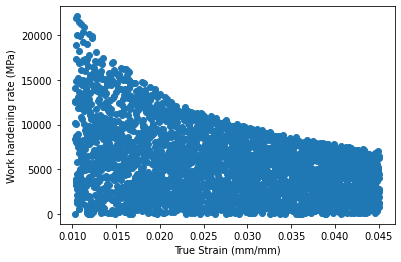

In [15]:
sigma_epsilon = np.divide(sanitised_true_stress, sanitised_true_strain)
d_sigma_epsilon = [work_hardening_exponent[i]*(sanitised_true_stress[i]/sanitised_true_strain[i]) for i in range(len(sanitised_true_stress))]
_ = plt.scatter(sanitised_true_strain, d_sigma_epsilon)
_ = plt.xlabel('True Strain (mm/mm)')
_ = plt.ylabel('Work hardening rate (MPa)')

### Plastic Strain Definition
<img src = "plasticstrain_def.png"/>

## Work Hardening Rate plot

In [16]:
# Determination of work hardening exponent using log(true stress) v/s log(true strain) plot
reshaped_log_true_strain = log_true_strain.reshape((-1, 1))
model = LinearRegression().fit(reshaped_log_true_strain, log_true_stress)
n_plot = model.score(reshaped_log_true_strain, log_true_stress)
Work_hardening_exponent = model.coef_
logk = model.intercept_
print ('Work hardening exponent:', Work_hardening_exponent[0])
print('coefficient of determination:', n_plot)
print('K:', np.exp(logk))

Work hardening exponent: 0.21238915726544266
coefficient of determination: 0.999194579205424
K: 619.2430234745813


In the plastic region, the true stress and true strain values satisfy:
$ \sigma = 619.243 * \epsilon^{0.212}$


$\frac{d\sigma}{d\epsilon} = n $ 

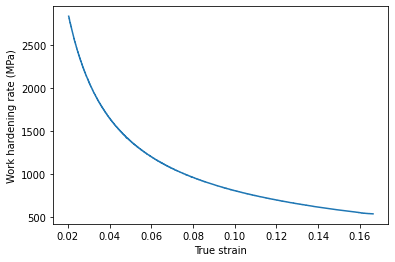

In [22]:
Work_hardening_rate = [Work_hardening_exponent[0]*true_stress[i]/true_strain[i] for i in range(965, required_points)]
plt.plot(true_strain[required_points_plasticity:], Work_hardening_rate)
_ = plt.ylabel('Work hardening rate (MPa)')
_ = plt.xlabel('True strain')